In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm, multivariate_normal
from scipy.optimize import curve_fit

from skopt.plots import plot_gaussian_process


In [19]:
x_range = np.linspace(0,150,100)
y_range = np.linspace(0,150,100)

xx, yy = np.meshgrid(x_range, y_range)

In [20]:
def multivariate_gaussian(pos, mu, Sigma):

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

In [21]:
grid = np.empty(xx.shape + (2,))

grid[:,:,0] = xx
grid[:,:,1] = yy

In [22]:
gaussians = [([50,50],[[600,25],[-90,110]]),
             ([90,30],[[700,-15],[-105,40]]),
             ([80,90],[[120,-25],[90,42]]),
             ([20,80],[[100,-25],[-55,400]]),
             ([40,80],[[100,0],[0,40]])
]

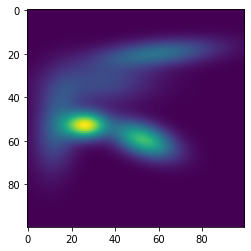

In [23]:
plt.imshow(np.sum([multivariate_gaussian(grid, np.array(mu), np.array(sig)) for mu, sig in gaussians], axis=0))

In [24]:
zz = np.sum([multivariate_gaussian(grid, np.array(mu), np.array(sig)) for mu, sig in gaussians] + 5e-5*np.random.random((100,100)), axis=0)

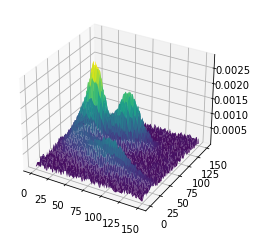

In [25]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf=ax.plot_surface(xx, yy, zz, cmap=cm.viridis)
#fig.colorbar(surf, shrink = 0.5, aspect = )

In [26]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

In [27]:
df = pd.DataFrame({'X': xx.ravel(), 'Y': yy.ravel(), 'Z': zz.ravel()})



In [28]:
kernel = 1.0 * Matern(length_scale=1.5, nu=1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/conor/miniconda3/envs/PHD/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown 

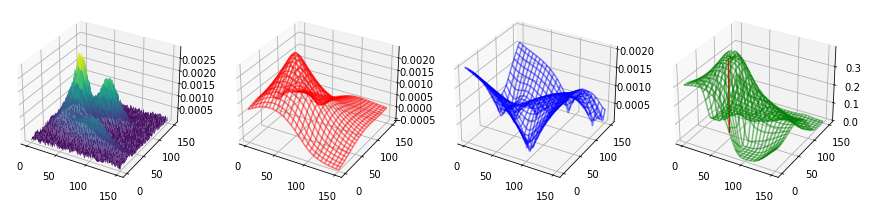

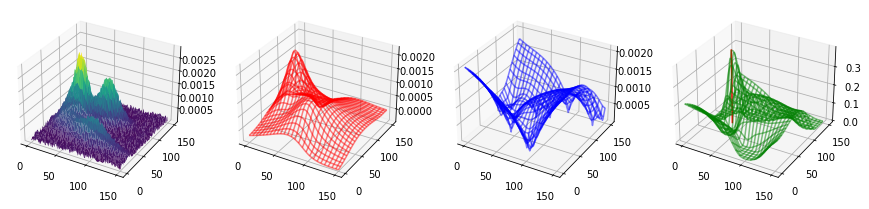

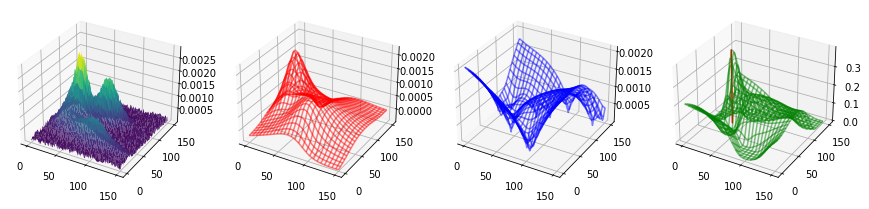

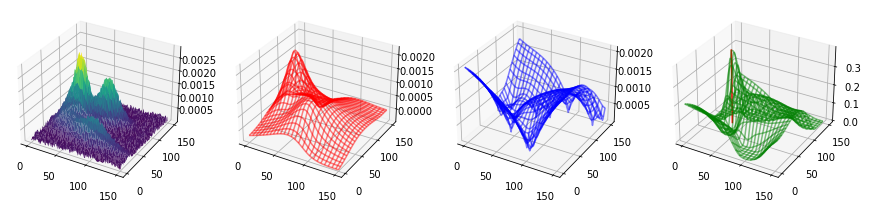

In [29]:
shuffled = df.sample(frac=1.0)

n_evaluations = 20
sampled_data = shuffled.iloc[:10,:]

for i in range(n_evaluations):

    gp.fit(sampled_data[['X','Y']].copy(), sampled_data['Z'].copy())
    y_pred, sigma = gp.predict(np.stack([xx.ravel(), yy.ravel()]).T, return_std=True)

    y_, _ = gp.predict(sampled_data[['X','Y']].copy(), return_std=True)
    y_max = np.max(y_)

    #z = np.min(y_pred.reshape(xx.shape)) - (y_pred.reshape(xx.shape) - 1.96 *sigma.reshape(xx.shape))
    EI = (y_max-y_pred)+norm.pdf((y_max-y_pred)/(sigma+1e-9))+sigma*norm.cdf((y_max-y_pred)/(sigma+1e-9))
    EI_i = np.argmax(EI)

    x_n = xx.ravel()[EI_i]
    y_n = yy.ravel()[EI_i]
    z_n = zz.ravel()[EI_i]

    next_ = {'X': x_n, 'Y': y_n, 'Z': z_n}

    sampled_data = sampled_data.append(next_, ignore_index=True)

    if i%5 ==0:

        fig = plt.figure(figsize=(15,10))
        ax1 = fig.add_subplot(1, 4, 1, projection='3d')
        ax1.plot_surface(xx, yy, zz, cmap=cm.viridis)

        ax2 = fig.add_subplot(1, 4, 2, projection='3d')
        ax2.plot_wireframe(xx, yy,  y_pred.reshape(xx.shape), color='red',  rstride=4, cstride=4, alpha=0.5)

        ax3 = fig.add_subplot(1, 4, 3, projection='3d')
        ax3.plot_wireframe(xx, yy, sigma.reshape(xx.shape), color='blue',  rstride=4, cstride=4, alpha=0.5)

        ax4 = fig.add_subplot(1, 4, 4, projection='3d')
        ax4.plot_wireframe(xx, yy, EI.reshape(xx.shape), color='green',  rstride=4, cstride=4, alpha=0.5)
        
        ax4.plot(np.array([x_n, x_n]), np.array([y_n, y_n]), np.array([0, np.max(EI)]), c='r')





In [30]:
np.argmax(zz.reshape(xx.shape))

5327

[]

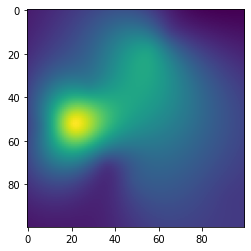

In [31]:
plt.imshow(y_pred.reshape(xx.shape))
plt.plot()

In [33]:
zz.argmax()

5327

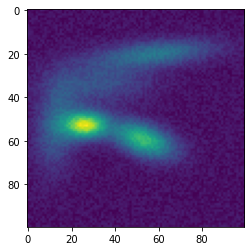

In [32]:
plt.imshow(zz)

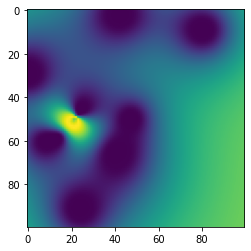

In [50]:
plt.imshow(EI.reshape(xx.shape))